# 8.3 Lab: Tree-Based Methods

## We import some of our usual libraries at this top level.

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.datasets import get_rdataset
import sklearn.model_selection as skm
from ISLP import load_data , confusion_table
from ISLP.models import ModelSpec as MS

## We also collect the new imports needed for this lab.

In [2]:
from sklearn.tree import (DecisionTreeClassifier as DTC ,
                          DecisionTreeRegressor as DTR ,
                          plot_tree ,
                          export_text)
from sklearn.metrics import (accuracy_score ,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
from ISLP.bart import BART

## 8.3.1 Fitting Classification Trees
We first use classification trees to analyze the Carseats data set. In these
data, Sales is a continuous variable, and so we begin by recoding it as a
binary variable. We use the where() function to create a variable, called where() High, which takes on a value of Yes if the Sales variable exceeds 8, and
takes on a value of No otherwise.

In [4]:
Carseats = load_data('Carseats')
High = np.where(Carseats.Sales > 8,
                "Yes",
                "No")
Carseats.head()

We now use DecisionTreeClassifier() to fit a classification tree in order 
to predict High using all variables but Sales. To do so, we must form a 
model matrix as we did when fitting regression models.

In [7]:
model = MS(Carseats.columns.drop('Sales'), intercept=False)
D = model.fit_transform(Carseats)
feature_names = list(D.columns)
X = np.asarray(D)

We have converted D from a data frame to an array X, which is needed in
some of the analysis below. We also need the feature_names for annotating
our plots later.
There are several options needed to specify the classifier, such as max_depth
(how deep to grow the tree), min_samples_split (minimum number of observations
in a node to be eligible for splitting) and criterion (whether to
use Gini or cross-entropy as the split criterion). We also set random_state
for reproducibility; ties in the split criterion are broken at random.

In [8]:
clf = DTC(criterion='entropy',
          max_depth=3,
          random_state=0)
clf.fit(X, High)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'entropy'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",3
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current 

In our discussion of qualitative features in Section 3.3, we noted that for
a linear regression model such a feature could be represented by including a
matrix of dummy variables (one-hot-encoding) in the model matrix, using
the formula notation of statsmodels. As mentioned in Section 8.1, there is
a more natural way to handle qualitative features when building a decision
tree, that does not require such dummy variables; each split amounts to
partitioning the levels into two groups. However, the sklearn implementation
of decision trees does not take advantage of this approach; instead it
simply treats the one-hot-encoded levels as separate variables.

In [9]:
accuracy_score(High , clf.predict(X))

0.79

In [10]:
resid_dev = np.sum(log_loss(High , clf.predict_proba(X)))
resid_dev

np.float64(0.47106470626493574)

This is closely related to the entropy, defined in (8.7). A small deviance
indicates a tree that provides a good fit to the (training) data.
One of the most attractive properties of trees is that they can be graphically
displayed. Here we use the plot() function to display the tree structure
(not shown here).

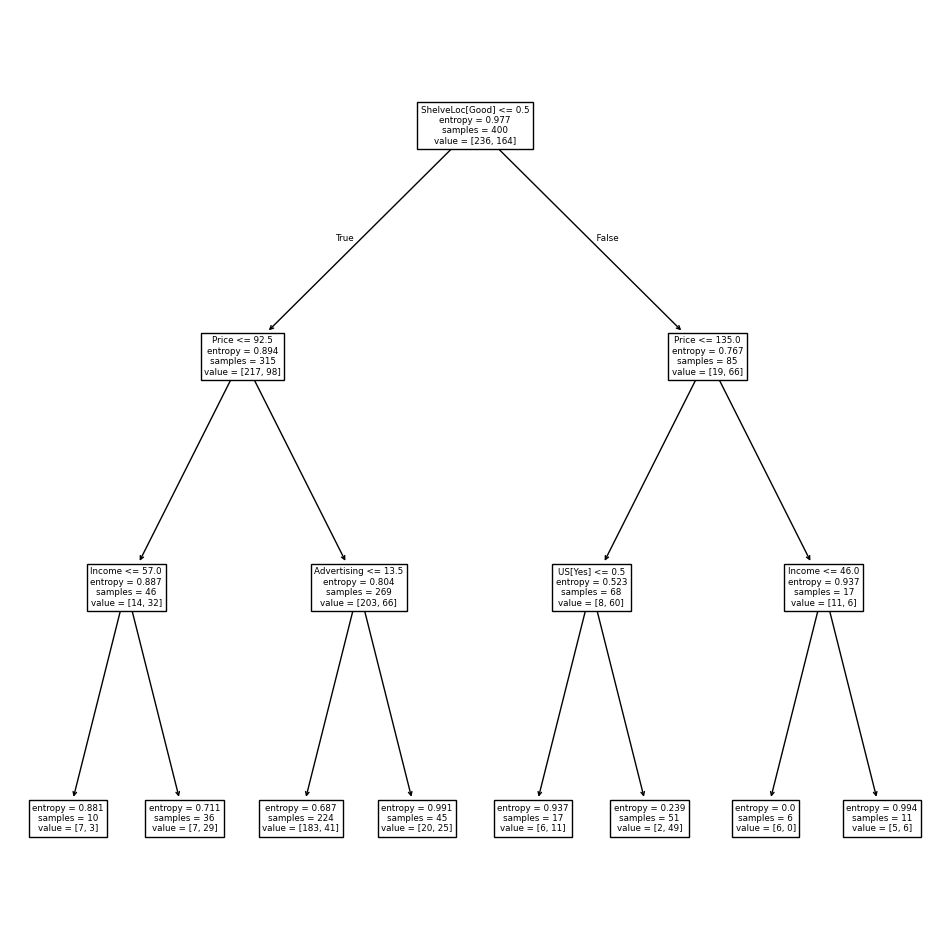

In [11]:
ax = subplots(figsize=(12,12))[1]
plot_tree(clf ,
          feature_names=feature_names ,
          ax=ax);

The most important indicator of Sales appears to be ShelveLoc.
We can see a text representation of the tree using export_text(), which displays the split criterion (e.g. Price <= 92.5) for each branch. For leaf 
nodes it shows the overall prediction (Yes or No). We can also see the number
of observations in that leaf that take on values of Yes and No by specifying
show_weights=True.

In [12]:
print(export_text(clf ,
                  feature_names=feature_names ,
                  show_weights=True))

|--- ShelveLoc[Good] <= 0.50
|   |--- Price <= 92.50
|   |   |--- Income <= 57.00
|   |   |   |--- weights: [7.00, 3.00] class: No
|   |   |--- Income >  57.00
|   |   |   |--- weights: [7.00, 29.00] class: Yes
|   |--- Price >  92.50
|   |   |--- Advertising <= 13.50
|   |   |   |--- weights: [183.00, 41.00] class: No
|   |   |--- Advertising >  13.50
|   |   |   |--- weights: [20.00, 25.00] class: Yes
|--- ShelveLoc[Good] >  0.50
|   |--- Price <= 135.00
|   |   |--- US[Yes] <= 0.50
|   |   |   |--- weights: [6.00, 11.00] class: Yes
|   |   |--- US[Yes] >  0.50
|   |   |   |--- weights: [2.00, 49.00] class: Yes
|   |--- Price >  135.00
|   |   |--- Income <= 46.00
|   |   |   |--- weights: [6.00, 0.00] class: No
|   |   |--- Income >  46.00
|   |   |   |--- weights: [5.00, 6.00] class: Yes



In order to properly evaluate the performance of a classification tree on
these data, we must estimate the test error rather than simply computing
the training error. We split the observations into a training set and a test
set, build the tree using the training set, and evaluate its performance
on the test data. This pattern is similar to that in Chapter 6, with the
linear models replaced here by decision trees — the code for validation is
almost identical. This approach leads to correct predictions for 68.5% of
the locations in the test data set.

In [13]:
validation = skm.ShuffleSplit(n_splits=1,
                              test_size=200,
                              random_state=0)
results = skm.cross_validate(clf ,
                             D,
                             High ,
                             cv=validation)
results['test_score']

array([0.685])

Next, we consider whether pruning the tree might lead to improved classification
performance. We first split the data into a training and test set.
We will use cross-validation to prune the tree on the training set, and then
evaluate the performance of the pruned tree on the test set.

In [14]:
(X_train ,
X_test ,
High_train ,
High_test) = skm.train_test_split(X,
                                  High ,
                                  test_size=0.5,
                                  random_state=0)

We first refit the full tree on the training set; here we do not set a max_depth
parameter, since we will learn that through cross-validation.

In [15]:
clf = DTC(criterion='entropy', random_state=0)
clf.fit(X_train , High_train)
accuracy_score(High_test , clf.predict(X_test))

0.735

Next we use the cost_complexity_pruning_path() method of clf to 
cost-complexity values.

In [16]:
ccp_path = clf.cost_complexity_pruning_path(X_train , High_train)
kfold = skm.KFold(10,
                  random_state=1,
                  shuffle=True)

This yields a set of impurities and ) values from which we can extract an
optimal one by cross-validation.

In [17]:
grid = skm.GridSearchCV(clf ,
                       {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True ,
                        cv=kfold ,
                        scoring='accuracy')
grid.fit(X_train , High_train)
grid.best_score_

np.float64(0.685)

Let’s take a look at the pruned true.

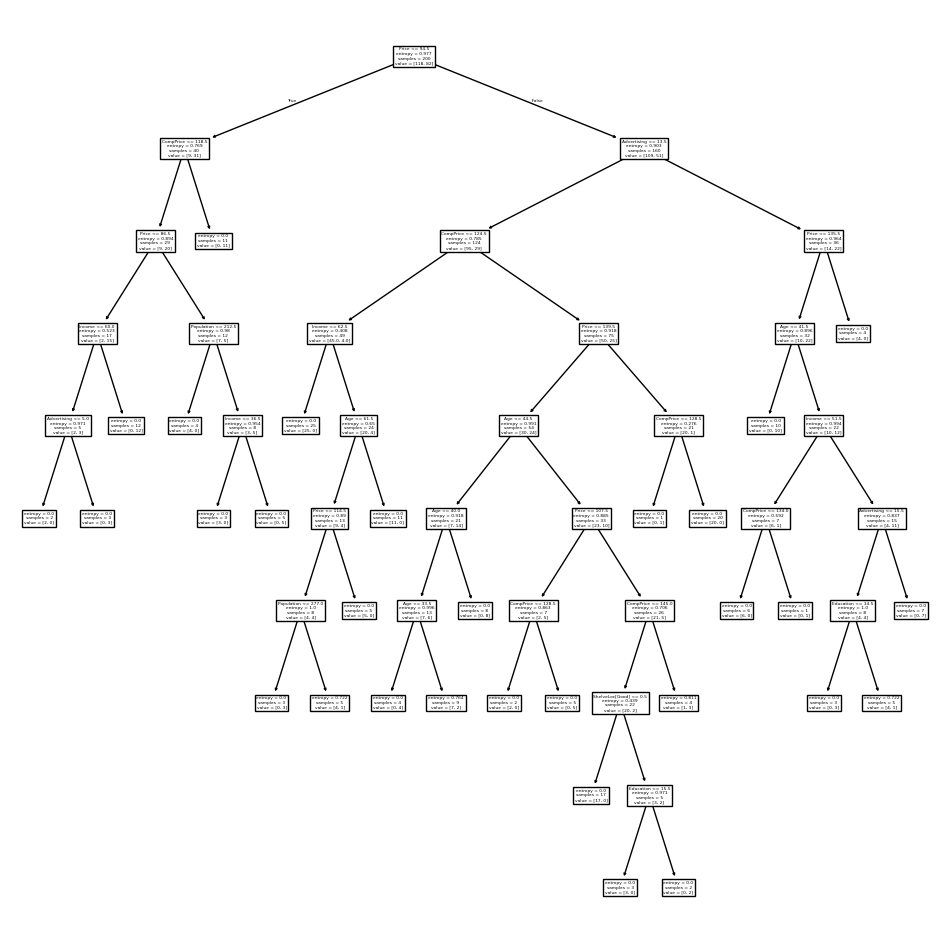

In [20]:
ax = subplots(figsize=(12, 12))[1]
best_ = grid.best_estimator_
plot_tree(best_ ,
          feature_names=feature_names ,
          ax=ax);

This is quite a bushy tree. We could count the leaves, or query best_ instead.

In [21]:
best_.tree_.n_leaves

np.int64(30)

The tree with 30 terminal nodes results in the lowest cross-validation error
rate, with an accuracy of 68.5%. How well does this pruned tree perform
on the test data set? Once again, we apply the predict() function.

In [23]:
print(accuracy_score(High_test ,
                     best_.predict(X_test)))
confusion = confusion_table(best_.predict(X_test),
                            High_test)
confusion

0.72


Truth,No,Yes
Predicted,,
No,94,32
Yes,24,50


### Now 72.0% of the test observations are correctly classified, which is slightly worse than the error for the full tree (with 35 leaves). So crossvalidation has not helped us much here; it only pruned off 5 leaves, at a cost of a slightly worse error. These results would change if we were to change the random number seeds above; even though cross-validation gives an unbiased approach to model selection, it does have variance.

# 8.3.2 Fitting Regression Trees

## Here we fit a regression tree to the Boston data set. The steps are similar to those for classification trees.

In [49]:
Boston = load_data("Boston")
model = MS(Boston.columns.drop('medv'), intercept=False)
D = model.fit_transform(Boston)
feature_names = list(D.columns)
X = np.asarray(D)

In [52]:
Boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


### First, we split the data into training and test sets, and fit the tree to the training data. Here we use 30% of the data for the test set.

In [25]:
(X_train ,
X_test ,
y_train ,
y_test) = skm.train_test_split(X,
                               Boston['medv'],
                               test_size=0.3,
                               random_state=0)

## Having formed our training and test data sets, we fit the regression tree.

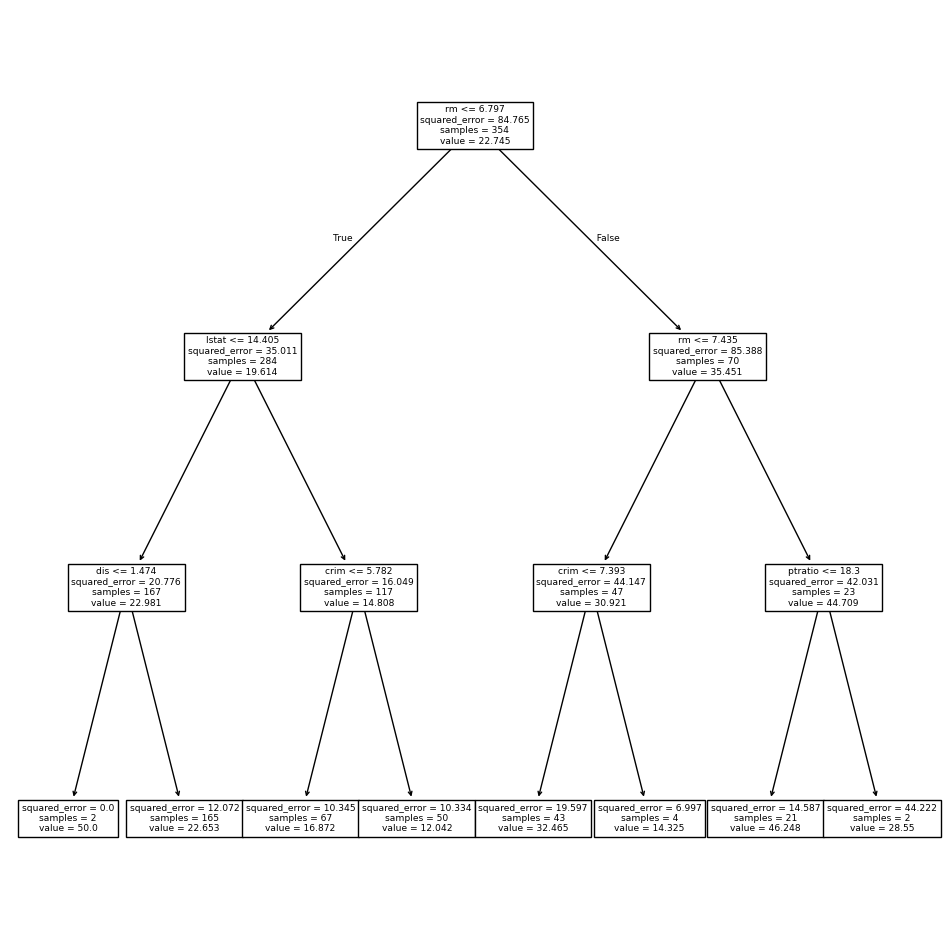

In [26]:
reg = DTR(max_depth=3)
reg.fit(X_train , y_train)
ax = subplots(figsize=(12,12))[1]
plot_tree(reg ,
          feature_names=feature_names ,
          ax=ax);

The variable lstat measures the percentage of individuals with lower
socioeconomic status. The tree indicates that lower values of lstat correspond
to more expensive houses. The tree predicts a median house price
of $12,042 for small-sized homes (rm < 6.8), in suburbs in which residents
have low socioeconomic status (lstat > 14.4) and the crime-rate is moderate
(crim > 5.8).
Now we use the cross-validation function to see whether pruning the tree
will improve performance.

In [27]:
ccp_path = reg.cost_complexity_pruning_path(X_train , y_train)
kfold = skm.KFold(5,
                  shuffle=True ,
                  random_state =10)
grid = skm.GridSearchCV(reg ,
                       {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True ,
                        cv=kfold ,
                        scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)

In keeping with the cross-validation results, we use the pruned tree to
make predictions on the test set.

In [28]:
best_ = grid.best_estimator_
np.mean((y_test - best_.predict(X_test))**2)

np.float64(28.06985754975404)

In other words, the test set MSE associated with the regression tree is
28.07. The square root of the MSE is therefore around 5.30, indicating that
this model leads to test predictions that are within around $5300 of the
true median home value for the suburb.
Let’s plot the best tree to see how interpretable it is.

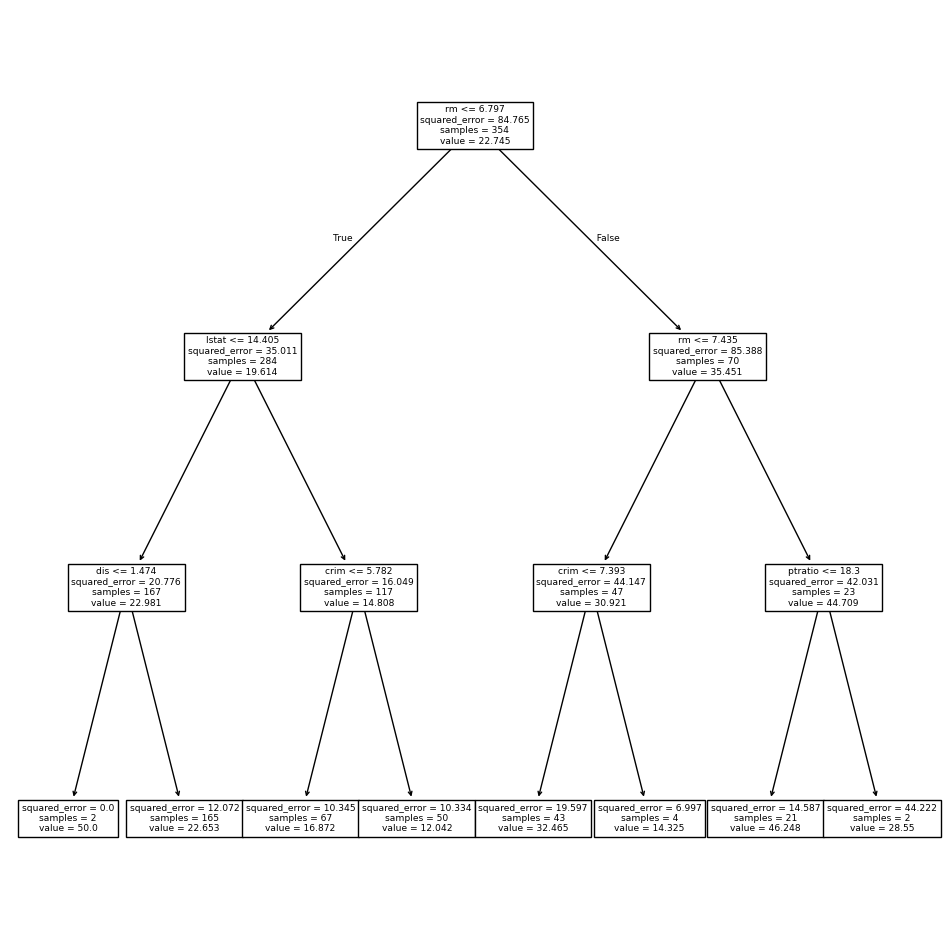

In [29]:
ax = subplots(figsize=(12,12))[1]
plot_tree(G.best_estimator_ ,
feature_names=feature_names ,
ax=ax);

## 8.3.3 Bagging and Random Forests 


Here we apply bagging and random forests to the Boston data, using the
RandomForestRegressor() from the sklearn.ensemble package. 
bagging is simply a special case of a random forest with m = p. Therefore,
the RandomForestRegressor() function can be used to perform both bagging
and random forests. We start with bagging.

In [30]:
bag_boston = RF(max_features=X_train.shape[1], random_state=0)
bag_boston.fit(X_train , y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",12
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples

The argument max_features indicates that all 12 predictors should be
considered for each split of the tree — in other words, that bagging should
be done. How well does this bagged model perform on the test set?

np.float64(14.634700151315787)

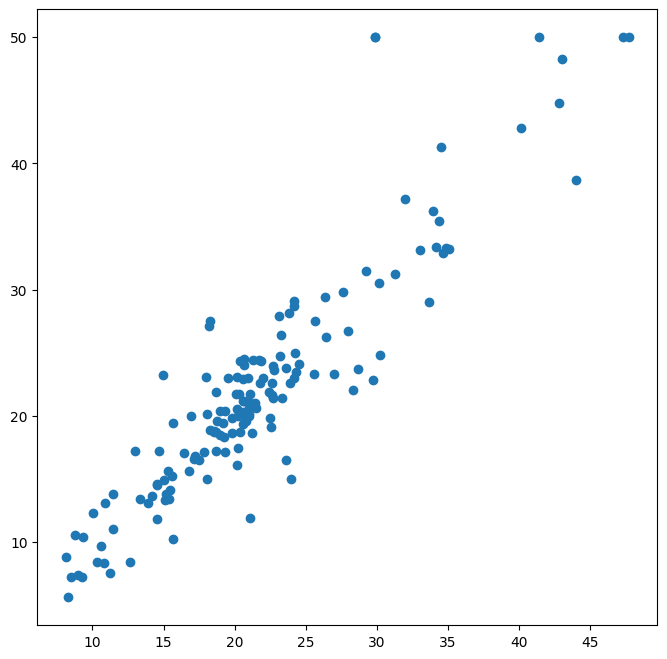

In [31]:
ax = subplots(figsize=(8,8))[1]
y_hat_bag = bag_boston.predict(X_test)
ax.scatter(y_hat_bag , y_test)
np.mean((y_test - y_hat_bag)**2)

The test set MSE associated with the bagged regression tree is 14.63, about
half that obtained using an optimally-pruned single tree. We could change
the number of trees grown from the default of 100 by using the n_estimators
argument:

In [32]:
bag_boston = RF(max_features=X_train.shape[1],
             n_estimators=500,
             random_state=0).fit(X_train , y_train)
y_hat_bag = bag_boston.predict(X_test)
np.mean((y_test - y_hat_bag)**2)

np.float64(14.605662565263161)

There is not much change. Bagging and random forests cannot overfit by
increasing the number of trees, but can underfit if the number is too small.
Growing a random forest proceeds in exactly the same way, except
that we use a smaller value of the max_features argument. By default,
RandomForestRegressor() uses p variables when building a random forest of
regression trees (i.e. it defaults to bagging), and RandomForestClassifier()
uses 'p variables when building a random forest of classification trees. Here
we use max_features=6.

In [33]:
RF_boston = RF(max_features=6,
            random_state=0).fit(X_train , y_train)
y_hat_RF = RF_boston.predict(X_test)
np.mean((y_test - y_hat_RF)**2)

np.float64(20.04276446710527)

The test set MSE is 20.04; this indicates that random forests did somewhat
worse than bagging in this case. Extracting the feature_importances_
values from the fitted model, we can view the importance of each variable.

In [34]:
feature_imp = pd.DataFrame(
             {'importance':RF_boston.feature_importances_},
              index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
lstat,0.356203
rm,0.332163
ptratio,0.067270
crim,0.055404
indus,0.053851
dis,0.041582
nox,0.035225
tax,0.025355
age,0.021506
rad,0.004784


This is a relative measure of the total decrease in node impurity that results
from splits over that variable, averaged over all trees (this was plotted in
Figure 8.9 for a model fit to the Heart data).
The results indicate that across all of the trees considered in the random
forest, the wealth level of the community (lstat) and the house size (rm)
are by far the two most important variables.

    
## 8.3.4 Boosting

    
Here we use GradientBoostingRegressor() from sklearn.ensemble to fit 
boosted regression trees to the Boston data set. For classification we would
use GradientBoostingClassifier(). The argument n_estimators=5000 indi-
cates that we want 5000 trees, and the option max_depth=3 limits the depth
of each tree. The argument learning_rate is the ! mentioned earlier in the
description of boosting.

In [36]:
boost_boston = GBR(n_estimators=5000,
               learning_rate =0.001,
               max_depth=3,
               random_state=0)
boost_boston.fit(X_train , y_train)

,"loss loss: {'squared_error', 'absolute_error', 'huber', 'quantile'}, default='squared_error'Loss function to be optimized. 'squared_error' refers to the squarederror for regression. 'absolute_error' refers to the absolute error ofregression and is a robust loss function. 'huber' is acombination of the two. 'quantile' allows quantile regression (use`alpha` to specify the quantile).See:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_quantile.py`for an example that demonstrates quantile regression for creatingprediction intervals with `loss='quantile'`.",'squared_error'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.",0.001
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",5000
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",1.0
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are""friedman_mse"" for the mean squared error with improvement score byFriedman, ""squared_error"" for mean squared error. The default value of""friedman_mse"" is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",3
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in thele

We can see how the training error decreases with the train_score_ attribute.
To get an idea of how the test error decreases we can use the
staged_predict() method to get the predicted values along the path.

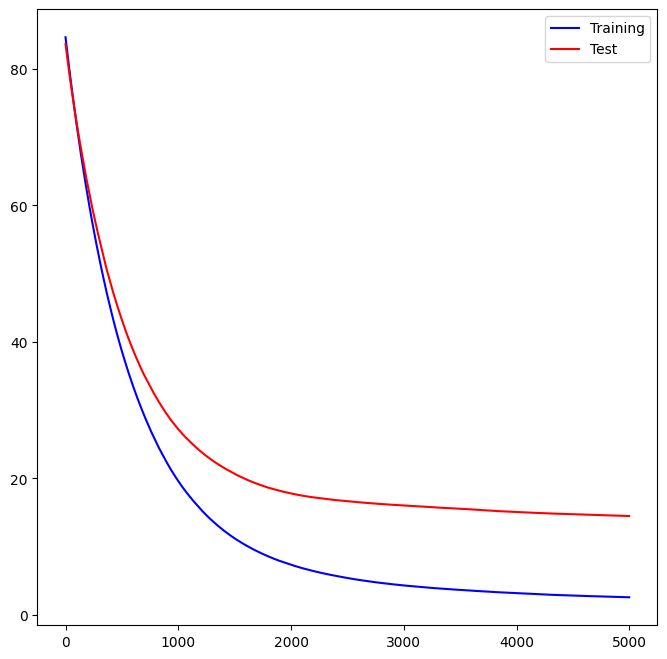

In [37]:
test_error = np.zeros_like(boost_boston.train_score_)
for idx , y_ in enumerate(boost_boston.staged_predict(X_test)):
    test_error[idx] = np.mean((y_test - y_)**2)
    
plot_idx = np.arange(boost_boston.train_score_.shape[0])
ax = subplots(figsize=(8,8))[1]
ax.plot(plot_idx ,
        boost_boston.train_score_ ,
        'b',
        label='Training')
ax.plot(plot_idx ,
        test_error ,
        'r',
        label='Test')
ax.legend();

We now use the boosted model to predict medv on the test set:

In [38]:
y_hat_boost = boost_boston.predict(X_test);
np.mean((y_test - y_hat_boost)**2)

np.float64(14.481405918831591)

The test MSE obtained is 14.48, similar to the test MSE for bagging. If we
want to, we can perform boosting with a different value of the shrinkage
parameter ! in (8.10). The default value is 0.001, but this is easily modified.
Here we take ! = 0.2.

In [39]:
boost_boston = GBR(n_estimators=5000,
                  learning_rate=0.2,
                  max_depth=3,
                  random_state=0)
boost_boston.fit(X_train ,
                 y_train)
y_hat_boost = boost_boston.predict(X_test);
np.mean((y_test - y_hat_boost)**2)

np.float64(14.501514553719565)

In this case, using ! = 0.2 leads to a almost the same test MSE as when
using ! = 0.001.

## 8.3.5 Bayesian Additive Regression Trees

In this section we demonstrate a Python implementation of BART found in
the ISLP.bart package. We fit a model to the Boston housing data set. This
BART() estimator is designed for quantitative outcome variables, though other implementations are available for fitting logistic and probit models 
to categorical outcomes.

In [40]:
bart_boston = BART(random_state=0, burnin=5, ndraw=15)
bart_boston.fit(X_train , y_train)

,num_trees,200
,num_particles,10
,max_stages,5000
,split_prob,<function BAR...0020E9CD81260>
,min_depth,0
,std_scale,2
,split_prior,None
,ndraw,15
,burnin,5
,sigma_prior,"(5, ...)"
,num_quantile,50


On this data set, with this split into test and training, we see that the
test error of BART is similar to that of random forest.

In [41]:
yhat_test = bart_boston.predict(X_test.astype(np.float32))
np.mean((y_test - yhat_test)**2)

np.float64(22.145009458109232)

We can check how many times each variable appeared in the collection
of trees. This gives a summary similar to the variable importance plot for
boosting and random forests.

In [46]:
var_inclusion = pd.Series(
    bart_boston.variable_inclusion_.mean(0),
    index=D.columns
)

var_inclusion

crim       26.933333
zn         27.866667
indus      26.466667
chas       22.466667
nox        26.600000
rm         29.800000
age        22.733333
dis        26.466667
rad        23.666667
tax        24.133333
ptratio    24.266667
lstat      31.000000
dtype: float64